In [ ]:
import os

import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from sentence_transformers import SentenceTransformer

In [2]:
kb_all = pd.read_csv('../KB_data.csv')
kb_all.head()

,msg_id,conv_id,conv_turn,sender_user_id,receiver_user_id,sent_at,text,answer
0,da909b73-688c-47fe-8c51-ce2f122a2736,chat:u_barbara_u_maayan_student_magshimim,1,u_maayan_student_magshimim,u_barbara,2025-01-06 17:37:39,"Hi, if it's possible to be a few minutes late,...","Yes, yes\nOne minute\nMaayan, something embarr..."
1,ddb46ea7-b3a7-4803-8404-423c49ccfbca,chat:u_barbara_u_maayan_student_magshimim,2,u_barbara,u_maayan_student_magshimim,2025-01-06 17:41:31,"Yes, yes\nOne minute\nMaayan, something embarr...","Okay\nRegarding homework 10, I got stuck debug..."
2,0c090651-7983-4a69-938a-0a53d41ce470,chat:u_barbara_u_maayan_student_magshimim,3,u_maayan_student_magshimim,u_barbara,2025-01-06 17:51:04,"Okay\nRegarding homework 10, I got stuck debug...","There's a part, one minute\nCheck if this is it"
3,bf35a2dd-5444-484d-99ff-b57ab7b20c2c,chat:u_barbara_u_maayan_student_magshimim,4,u_barbara,u_maayan_student_magshimim,2025-01-06 18:24:15,"There's a part, one minute\nCheck if this is it","I just got a moment to write this, sorry"
4,0db5bc6f-179e-46c1-8ba0-6c2f3e296082,chat:u_barbara_u_maayan_student_magshimim,5,u_maayan_student_magshimim,u_barbara,2025-01-06 18:24:21,"I just got a moment to write this, sorry","Oh, ugh, I don't have any messages on WhatsApp..."


In [3]:
users_messages = {user : kb_all[kb_all["sender_user_id"] == user] for user in kb_all['sender_user_id'].unique()}

In [4]:
def embed_messages(users_messages: Dict[int, DataFrame],
                   model_name: str = 'all-MiniLM-L6-v2'):
    """
    Embed messages for each user using a pre-trained SentenceTransformer model.

    Args:
        users_messages (Dict[int, DataFrame]): A dictionary where keys are user IDs and values are DataFrames containing messages.
        model_name (str): The name of the pre-trained SentenceTransformer model to use.

    Returns:
        Tuple[Dict[int, np.ndarray], Dict[int, np.ndarray]]: Two dictionaries containing centroids and embeddings for each user.
    """
    embed_model = SentenceTransformer(model_name)
    centroids = {}
    embeddings = {}

    for user, user_df in users_messages.items():
        lines = [str(msg) for msg in user_df["text"].tolist()]
        msgs = "\n".join(lines)
        
        messages_emb = embed_model.encode(
            msgs,
            batch_size=16,
            convert_to_numpy=True,
            show_progress_bar=False
        ).reshape(1, -1)

        # Compute centroids for every speaker     
        centroids[user] = messages_emb.mean(axis=0).reshape(1, -1)
        embeddings[user] = messages_emb

    return centroids, embeddings

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_centroids_with_pca(centroids, title):
    """
    Plots centroids after applying PCA to reduce dimensions to 2D.
    
    Args:
        centroids (dict): A dictionary where keys are labels and values are high-dimensional arrays.
        title (str): The title of the plot.
    """
    # Extract labels and high-dimensional vectors
    labels = list(centroids.keys())
    vectors = np.array(list(centroids.values()))
    
    # Flatten vectors if they are multi-dimensional arrays
    vectors = np.squeeze(vectors)
    
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    
    # Define colors
    base_colors = ['red', 'lightpink', 'lightgreen', 'orange', 'purple', 'cyan']
    
    # Extend colors if needed
    colors = (base_colors * (len(vectors_2d) // len(base_colors) + 1))[:len(vectors_2d)]
    
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility
    
    # Plot each centroid
    for i, (x, y) in enumerate(vectors_2d):
        plt.scatter(x, y, 
                    color=colors[i], 
                    s=300,  # Increase marker size
                    edgecolor="black", 
                    label=labels[i])  # Add label for the legend
    
    # Add legend
    plt.legend(title="Users", fontsize=12, title_fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
    
    # Add gridlines for better readability
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Add title and axis labels
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

## All users 

In [12]:
centroids, embeddings = embed_messages(users_messages)

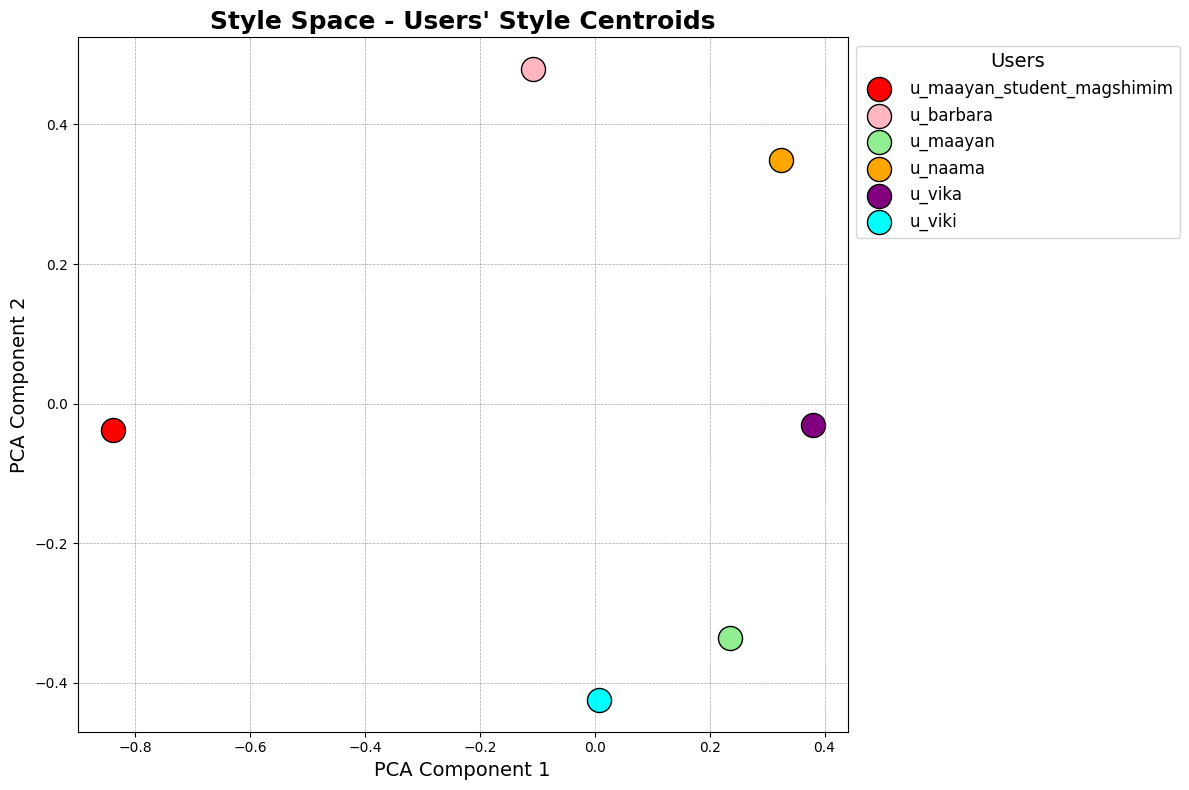

In [13]:
plot_centroids_with_pca(centroids, title="Style Space - Users' Style Centroids")

## Same user - Different conversations

In [14]:
barbara_conversations = {f"u_barbara-->{user}" : kb_all[(kb_all["sender_user_id"] == 'u_barbara')\
                             & (kb_all["receiver_user_id"] == user)]  for user in kb_all['receiver_user_id'].unique() \
                                if user != 'u_barbara'}

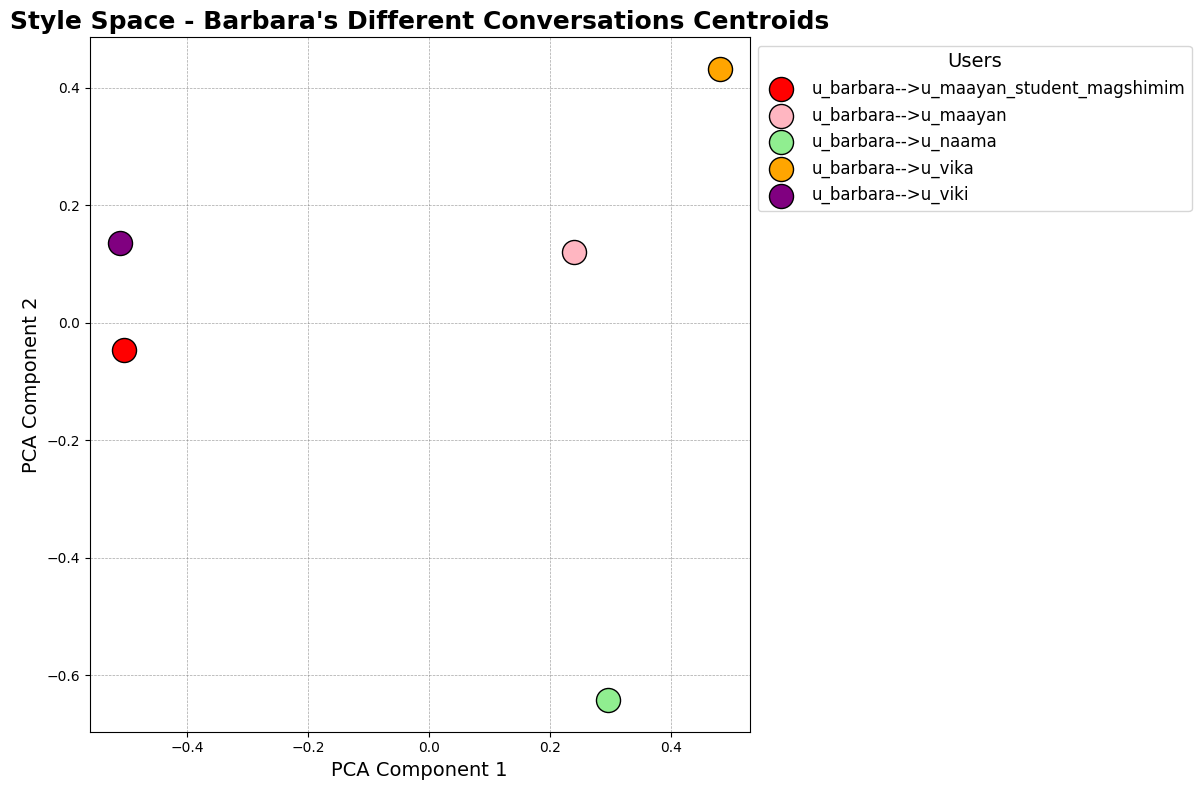

In [16]:
barbaara_centroids, barbara_embeddings = embed_messages(barbara_conversations)
plot_centroids_with_pca(barbaara_centroids, title="Style Space - Barbara's Different Conversations Centroids")